# import utilisé dans le programme

In [1]:
#import standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import CNN
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras import Input
from keras import Model
 
#import image
from matplotlib.image import imread
from itertools import chain
import matplotlib.image as mpimg
from io import BytesIO, StringIO
import cv2

import os
from glob import glob

#amazon
import boto3

import time

#classification
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# import PYSPARK

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

from pyspark.sql.functions import pandas_udf, PandasUDFType, udf, split
from pyspark.sql import Window, SQLContext
from pyspark.sql.types import StructType,StructField, StringType
from pyspark.sql.types import IntegerType, ArrayType, BinaryType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT


log4jLogger = spark.sparkContext._jvm.org.apache.log4j 
log = log4jLogger.LogManager.getLogger(__name__) 

# definition des storages S3 pour les images

In [3]:
s3 = boto3.resource('s3')

In [4]:
#verification liaison S3 OK
for bucket in s3.buckets.all():
    print(bucket.name)

elasticbeanstalk-eu-west-3-636121414640
elp-fruits-data-train1
elp-oc-p8-data
elp-oc-p8-data-20
elp-oc-p8-data-csv
elp-oc-p8-data-preprocess


In [5]:
#compact
bucket_str_data = 'elp-oc-p8-data'
bucket_str_data_upload = 'elp-oc-p8-data-preprocess'
bucket_str_data_csv = 'elp-oc-p8-data-csv'
echantillon = "data_sample_009/"

uri_data_S3 = "s3a://"+bucket_str_data+"/"+echantillon
uri_data_upload_S3 = "s3a://"+bucket_str_data_upload+"/"+echantillon

bucket = s3.Bucket(bucket_str_data)
bucket_upload = s3.Bucket(bucket_str_data_upload)
#bucket_csv = s3.Bucket(bucket_str_data_csv)

# chargement des images

In [6]:
#spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', "xxxx")
#spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', "xxx")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.profile.ProfileCredentialsProvider")

In [7]:
img_df = spark.read.format("image").load(uri_data_S3+"*/*.jpg")

In [8]:
img_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [9]:
img = img_df.select("image.data").take(1)[0][0]

In [10]:
img_rgb = np.array(img).reshape(100,100,3)

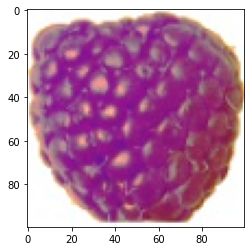

In [11]:
plt.figure(figsize=(4, 4))
plt.imshow(img_rgb)
plt.show()


In [12]:
img_df2 = img_df.withColumn("categ", split("image.origin","/").getItem(4))

In [13]:
img_df3 = img_df2.withColumn("file", split("image.origin","/").getItem(5))

In [14]:
img_df3.select("image.origin", "categ", "file").take(1)

[Row(origin='s3a://elp-oc-p8-data/data_sample_009/Raspberry/156_100.jpg', categ='Raspberry', file='156_100.jpg')]

In [15]:
def def_key(categ, file):
    return(categ+"/"+file)

def_key_UDF = udf(def_key, StringType())

In [16]:
img_df4 = img_df3.withColumn("key", def_key_UDF("categ","file"))

In [17]:
img_df4.select('categ', 'file', 'key').take(1)

[Row(categ='Raspberry', file='156_100.jpg', key='Raspberry/156_100.jpg')]

In [18]:
img_df4.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- categ: string (nullable = true)
 |-- file: string (nullable = true)
 |-- key: string (nullable = true)



# Preprocess des images 

In [19]:
def preprocess_image(data):
    img_rgb = np.array(data).reshape(100,100,3)
    image_blur = cv2.GaussianBlur(img_rgb, (3, 3), 0)
    image_resize = cv2.resize(image_blur, (224, 224))
    image_retour = cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB)
    image_flatten = image_retour.flatten()
    image_bytes = image_flatten.tobytes()
    return image_bytes
    
preprocess_imageUDF = udf(preprocess_image, BinaryType())

spark_preproces = img_df4.withColumn("preprocess_data", preprocess_imageUDF("image.data"))

In [20]:
img_preprocess = spark_preproces.select("preprocess_data").take(1)

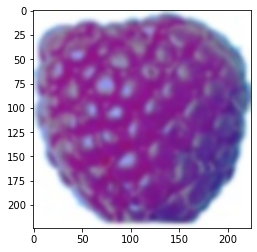

In [21]:
img_preprocess = np.array(img_preprocess[0][0]).reshape(224,224,3)
plt.figure(figsize=(4, 4))
plt.imshow(img_preprocess)
plt.show()


In [22]:
spark_preproces.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- categ: string (nullable = true)
 |-- file: string (nullable = true)
 |-- key: string (nullable = true)
 |-- preprocess_data: binary (nullable = true)



In [23]:
def upload_S3(vgg_image, image_key):
    """
        input : ( image a sauver, KEY dans bucket S3 pour sauver )
    """
#    print("envoi : ",image_key)
    image_np = np.array(vgg_image).reshape(224,224,3)

    img_data = BytesIO()
    plt.figure(figsize=(2.24, 2.24), dpi=100, clear=True)
    plt.imshow(image_np)
    plt.axis('off')
    plt.savefig(img_data, format='jpeg', dpi=100)
    img_data.seek(0)
    cle = echantillon+str(image_key)
    bucket_upload.put_object(Body=img_data, ContentType='image/jpeg', Key=cle)
    plt.close()
    
    return "OK"

upload_S3UDF = udf(upload_S3, StringType())




In [24]:
img = spark_preproces.select("preprocess_data", "key").head(1)[0]['preprocess_data']
k = spark_preproces.select("preprocess_data", "key").head(1)[0]['key']

In [25]:
k

'Raspberry/156_100.jpg'

In [26]:
upload_S3(img, k)

'OK'

In [27]:
spark_save = spark_preproces.select("preprocess_data", "key").collect()

In [28]:
for i,elt in enumerate(spark_save):
    if i%50 == 0 : print(i)
    upload_S3(elt['preprocess_data'], elt['key'])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


# extraction features par transfer learning

In [62]:
#creation liste images
file_s3_upload = []
rep_rech = echantillon+"/*.jpg"
for i,file in enumerate(bucket_upload.objects.filter(Prefix=echantillon)):
    if i%50 == 0 : print(i)
    elt = str(file.key).split("/")[1]
    s3_object = s3.Object(bucket_str_data_upload, file.key)
    image_bytes = s3_object.get()['Body'].read()
    file_s3_upload.append((elt,  file.key, image_bytes))

print(len(file_s3_upload), "images chargées")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1179 images chargées


In [63]:
df_files3_upload = pd.DataFrame(file_s3_upload, columns=['categ', 'key', 'data'])

In [64]:
df_files3_upload

,categ,key,data
0,Apple_Braeburn,data_sample_009/Apple_Braeburn/104_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1,Apple_Braeburn,data_sample_009/Apple_Braeburn/197_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
2,Apple_Braeburn,data_sample_009/Apple_Braeburn/229_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
3,Apple_Braeburn,data_sample_009/Apple_Braeburn/24_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
4,Apple_Braeburn,data_sample_009/Apple_Braeburn/250_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
...,...,...,...
1174,Watermelon,data_sample_009/Watermelon/310_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1175,Watermelon,data_sample_009/Watermelon/r_157_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1176,Watermelon,data_sample_009/Watermelon/r_257_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...
1177,Watermelon,data_sample_009/Watermelon/r_295_100.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


In [65]:
structureSchema = StructType([
         StructField('categ', StringType(), True),
         StructField('key', StringType(), True),
        StructField('image', BinaryType(), True)
         ])

spark_df_files3_upload = spark.createDataFrame(data=df_files3_upload,schema=structureSchema)

In [66]:
spark_df_files3_upload.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)



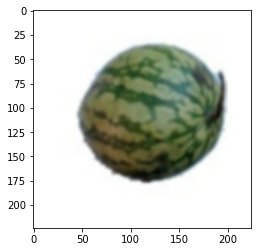

In [67]:
image_orig = spark_df_files3_upload.select("image").head(1)[0][0]
image_RGB = mpimg.imread(BytesIO(image_bytes), 'jpg')
plt.figure(figsize=(4, 4))
plt.imshow(image_RGB)
plt.show()


In [68]:
#utilisation transfer learning pour extraction features 
resnet = ResNet50()
# remove the output layer
model = Model(inputs=resnet.inputs, outputs=resnet.layers[-2].output)
#model.summary()

In [69]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [70]:
def model_fn():
    modelvgg = ResNet50(weights=None)
    model = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
    model.set_weights(bc_model_weights.value)
    return model

In [71]:
image_orig = spark_df_files3_upload.select("image").head(1)[0][0]
image_RGB = mpimg.imread(BytesIO(image_bytes), 'jpg')
# convert the image pixels to a numpy array
image = img_to_array(image_RGB)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


print('image', image.shape)
features = model.predict(image)
print('features', features.shape)


image (1, 224, 224, 3)
features (1, 2048)


In [72]:
@pandas_udf("array<float>")
def func(ser: pd.Series) -> pd.Series:
    mod = model_fn()
    lis = []
    for i in ser:
        image_RGB = mpimg.imread(BytesIO(i), 'jpg')
        image = img_to_array(image_RGB)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        features = mod.predict(image)  
        lis.append(features[0])
    return pd.Series(lis)



In [73]:
spark_df_vgg = spark_df_files3_upload.withColumn("vgg_feat", func("image"))

In [74]:
spark_df_vgg.show()

+------------------+--------------------+--------------------+--------------------+
|             categ|                 key|               image|            vgg_feat|
+------------------+--------------------+--------------------+--------------------+
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4115778, 0.989...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4248585, 0.343...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.0638742, 0.519...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.6853436, 0.840...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.88238835, 0.93...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.9579362, 0.002...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[2.9778574, 0.533...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.6637143, 0.340...|
|    Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.9141861, 0.

In [75]:
spark_df_vgg.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)
 |-- vgg_feat: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [76]:
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

spark_df_vgg_vector = spark_df_vgg.withColumn("vgg_vectores", to_vector("vgg_feat"))

In [77]:
n_components = 50
pca = PCA(
    k = n_components, 
    inputCol = 'vgg_vectores', 
    outputCol = 'pcaFeatures'
).fit(spark_df_vgg_vector)

df_pca = pca.transform(spark_df_vgg_vector)
print('Explained Variance Ratio', pca.explainedVariance.toArray().sum())

Explained Variance Ratio 0.8221906508661363


In [78]:
df_pca.show(6)

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         categ|                 key|               image|            vgg_feat|        vgg_vectores|         pcaFeatures|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4115778, 0.989...|[1.41157782077789...|[14.2660163915501...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4248585, 0.343...|[1.42485845088958...|[11.5431939772937...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.0638742, 0.519...|[1.06387424468994...|[11.9131939047429...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.6853436, 0.840...|[0.68534362316131...|[14.4837478904556...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.88238835, 0.93...|[0.88238835334777...|[13.3708558992965...|
|Apple_Braeburn|data_sam

In [79]:
from pyspark.ml.functions import vector_to_array

df = df_pca.withColumn('pcaFeatures', vector_to_array('pcaFeatures'))

df.printSchema()

root
 |-- categ: string (nullable = true)
 |-- key: string (nullable = true)
 |-- image: binary (nullable = true)
 |-- vgg_feat: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vgg_vectores: vector (nullable = true)
 |-- pcaFeatures: array (nullable = false)
 |    |-- element: double (containsNull = false)



In [80]:
df_vgg = df_pca.select('pcaFeatures').toPandas()

In [81]:
def compute_row(row):
    tre = []
    for elt in row.values[0]:
        tre.append(elt)
    return pd.Series(tre)
    
pca_vgg = df_vgg.apply(compute_row, axis=1) 

In [82]:
pca_vgg

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,14.266016,0.128370,-3.458534,6.208154,-3.613739,8.307157,7.413916,-9.161757,0.809158,1.036468,...,1.649814,5.356134,1.364862,-3.801546,4.218224,-0.255555,-1.614110,4.608141,-1.663034,-1.298292
1,11.543194,-2.050321,-4.322472,3.077217,-1.999651,8.880714,4.197673,-6.266713,2.606475,-2.253946,...,2.911916,4.947032,2.424684,-3.343833,4.269144,-0.259239,-1.381996,4.068548,-0.627342,-0.253540
2,11.913194,0.742721,-4.335120,3.311911,-3.468766,7.651888,3.501347,-5.085872,0.361147,0.133559,...,2.834105,5.261248,1.644088,-3.187427,4.248883,-0.335854,-0.640412,4.218903,-0.749063,-1.379213
3,14.483748,1.560441,-4.938266,5.609929,-5.810749,8.927020,5.811821,-7.508893,0.554113,-1.448907,...,2.471054,4.964083,1.864964,-2.391550,4.946434,-1.197953,-0.700164,3.911924,-2.064786,-0.832735
4,13.370856,3.338019,-4.725264,2.556462,-3.153569,6.701243,3.386728,-6.783923,2.228187,0.721305,...,2.412863,4.902359,1.832474,-3.495581,5.118708,-1.044158,-0.735094,4.615570,-1.227325,-2.081157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,-3.766192,3.686827,4.329697,-1.062805,1.788150,12.488996,5.803730,-4.292568,4.334457,7.778733,...,0.824164,3.491099,2.994982,-1.432803,3.453413,-2.169003,-0.984408,5.042486,-0.444600,-1.983312
1175,-4.693563,4.293499,2.431242,-0.783624,3.411502,10.608079,4.575590,-2.191322,7.039688,0.880935,...,1.765008,5.546032,2.433532,-2.498307,5.537584,-1.219771,-1.244402,4.109712,-0.766892,-2.655546
1176,-5.439177,5.510882,0.009116,-3.046757,-0.497698,11.188772,-0.767941,-3.102677,0.276450,-1.054458,...,2.710160,5.556534,2.351332,-1.262644,3.692558,-2.077508,0.032374,4.846578,-1.690179,-2.307015
1177,-5.098467,8.029458,2.198745,-0.675132,1.172577,12.894797,4.506676,-3.765909,7.889559,1.135329,...,2.398104,6.824380,3.651826,-3.265978,4.138153,-2.108795,-0.829241,5.273369,-0.603431,-3.324496


In [83]:
csv_buffer = StringIO()
pca_vgg.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_pca.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': '5RS7RY1TP7W9EARA',
  'HostId': 'd0oQf8qvcqx2ozGxiA8HeEStfA3UUePPf/wjhzr9ddT/MWZ4AS//FuGVjGS97BCgpugXdX7qiQE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'd0oQf8qvcqx2ozGxiA8HeEStfA3UUePPf/wjhzr9ddT/MWZ4AS//FuGVjGS97BCgpugXdX7qiQE=',
   'x-amz-request-id': '5RS7RY1TP7W9EARA',
   'date': 'Thu, 16 Sep 2021 15:40:22 GMT',
   'etag': '"dfa4a39c3141a579191a5a1e1645bcc7"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"dfa4a39c3141a579191a5a1e1645bcc7"'}

In [84]:
df_categ = df_pca.select('categ', 'key').toPandas()

In [85]:
df_categ

,categ,key
0,Apple_Braeburn,data_sample_009/Apple_Braeburn/104_100.jpg
1,Apple_Braeburn,data_sample_009/Apple_Braeburn/197_100.jpg
2,Apple_Braeburn,data_sample_009/Apple_Braeburn/229_100.jpg
3,Apple_Braeburn,data_sample_009/Apple_Braeburn/24_100.jpg
4,Apple_Braeburn,data_sample_009/Apple_Braeburn/250_100.jpg
...,...,...
1174,Watermelon,data_sample_009/Watermelon/310_100.jpg
1175,Watermelon,data_sample_009/Watermelon/r_157_100.jpg
1176,Watermelon,data_sample_009/Watermelon/r_257_100.jpg
1177,Watermelon,data_sample_009/Watermelon/r_295_100.jpg


In [86]:
csv_buffer = StringIO()
df_categ.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_categ.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '5RS9EVFM0QG2SD3M',
  'HostId': 'SKkHFadklqCXa854H+HapH6Zhj7HifdlAZr/er/FArJaTA3aDsv9s3WuH5O7GyP4sZizT1hE7t0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'SKkHFadklqCXa854H+HapH6Zhj7HifdlAZr/er/FArJaTA3aDsv9s3WuH5O7GyP4sZizT1hE7t0=',
   'x-amz-request-id': '5RS9EVFM0QG2SD3M',
   'date': 'Thu, 16 Sep 2021 15:40:22 GMT',
   'etag': '"d206c3c7ccfd3efe11e986eb5168f49e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d206c3c7ccfd3efe11e986eb5168f49e"'}

# suite pour classification et affichage non demandé

### Kmeans pour classifier

In [87]:
km_acp = KMeans(n_clusters=131)
km_acp.fit(pca_vgg)


KMeans(n_clusters=131)

In [88]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(km_acp.labels_, df_categ.categ)

0.4145055999316087

### PCA 2 dimension et TSNE pour affichage

In [89]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'vgg_vectores', 
    outputCol = 'pca2D'
).fit(spark_df_vgg_vector)

df_affic = pca.transform(spark_df_vgg_vector)
print('Explained Variance Ratio', pca.explainedVariance.toArray().sum())
df_affic.show(6)

Explained Variance Ratio 0.21821521049895073
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         categ|                 key|               image|            vgg_feat|        vgg_vectores|               pca2D|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4115778, 0.989...|[1.41157782077789...|[14.2660163915501...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.4248585, 0.343...|[1.42485845088958...|[11.5431939772937...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[1.0638742, 0.519...|[1.06387424468994...|[11.9131939047429...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.6853436, 0.840...|[0.68534362316131...|[14.4837478904556...|
|Apple_Braeburn|data_sample_009/A...|[FF D8 FF E0 00 1...|[0.88238835, 0.93...|[0.88238835334777...|[

In [90]:
df_vgg = df_affic.select('pca2D').toPandas()
pca_affic = df_vgg.apply(compute_row, axis=1) 
pca_affic.columns=['X','Y']
pca_affic

,X,Y
0,14.266016,0.128370
1,11.543194,-2.050321
2,11.913194,0.742721
3,14.483748,1.560441
4,13.370856,3.338019
...,...,...
1174,-3.766192,3.686827
1175,-4.693563,4.293499
1176,-5.439177,5.510882
1177,-5.098467,8.029458


In [91]:
csv_buffer = StringIO()
pca_affic.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_pca_affichage2D.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'YEHSW5G5AG859WN1',
  'HostId': 'DpjNufV06npcABCfo7DJvjIKsRye+CxjK19/PtC62k8lxd9Q2v8xVmFlki1nANEYmEQf+/XpwIY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'DpjNufV06npcABCfo7DJvjIKsRye+CxjK19/PtC62k8lxd9Q2v8xVmFlki1nANEYmEQf+/XpwIY=',
   'x-amz-request-id': 'YEHSW5G5AG859WN1',
   'date': 'Thu, 16 Sep 2021 16:55:33 GMT',
   'etag': '"b23bfc5c8e8967a1d7ae407ae4ffd8da"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b23bfc5c8e8967a1d7ae407ae4ffd8da"'}

In [92]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=1944)

X_tsne_sift = tsne.fit_transform(pca_vgg)
df_tsne_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
print(X_tsne_sift.shape)


(1179, 2)


In [93]:
csv_buffer = StringIO()
df_tsne_sift.to_csv(csv_buffer, sep=';')
s3_resource = boto3.resource('s3')
file_csv = echantillon+'df_features_tsne_affichage2D.csv'
s3_resource.Object(bucket_str_data_csv, file_csv).put(Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'Q2HZTG6B1JTBKX9G',
  'HostId': 'HD3puFm1RZY6LDENZuyXFgDMcBILz6OGFFXP8wSWP84dB07DVtq39ZJ46k1rpEwtTbCaoHxPoWc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'HD3puFm1RZY6LDENZuyXFgDMcBILz6OGFFXP8wSWP84dB07DVtq39ZJ46k1rpEwtTbCaoHxPoWc=',
   'x-amz-request-id': 'Q2HZTG6B1JTBKX9G',
   'date': 'Thu, 16 Sep 2021 16:55:45 GMT',
   'etag': '"f52b42bd25d976af97f4864903515345"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"f52b42bd25d976af97f4864903515345"'}

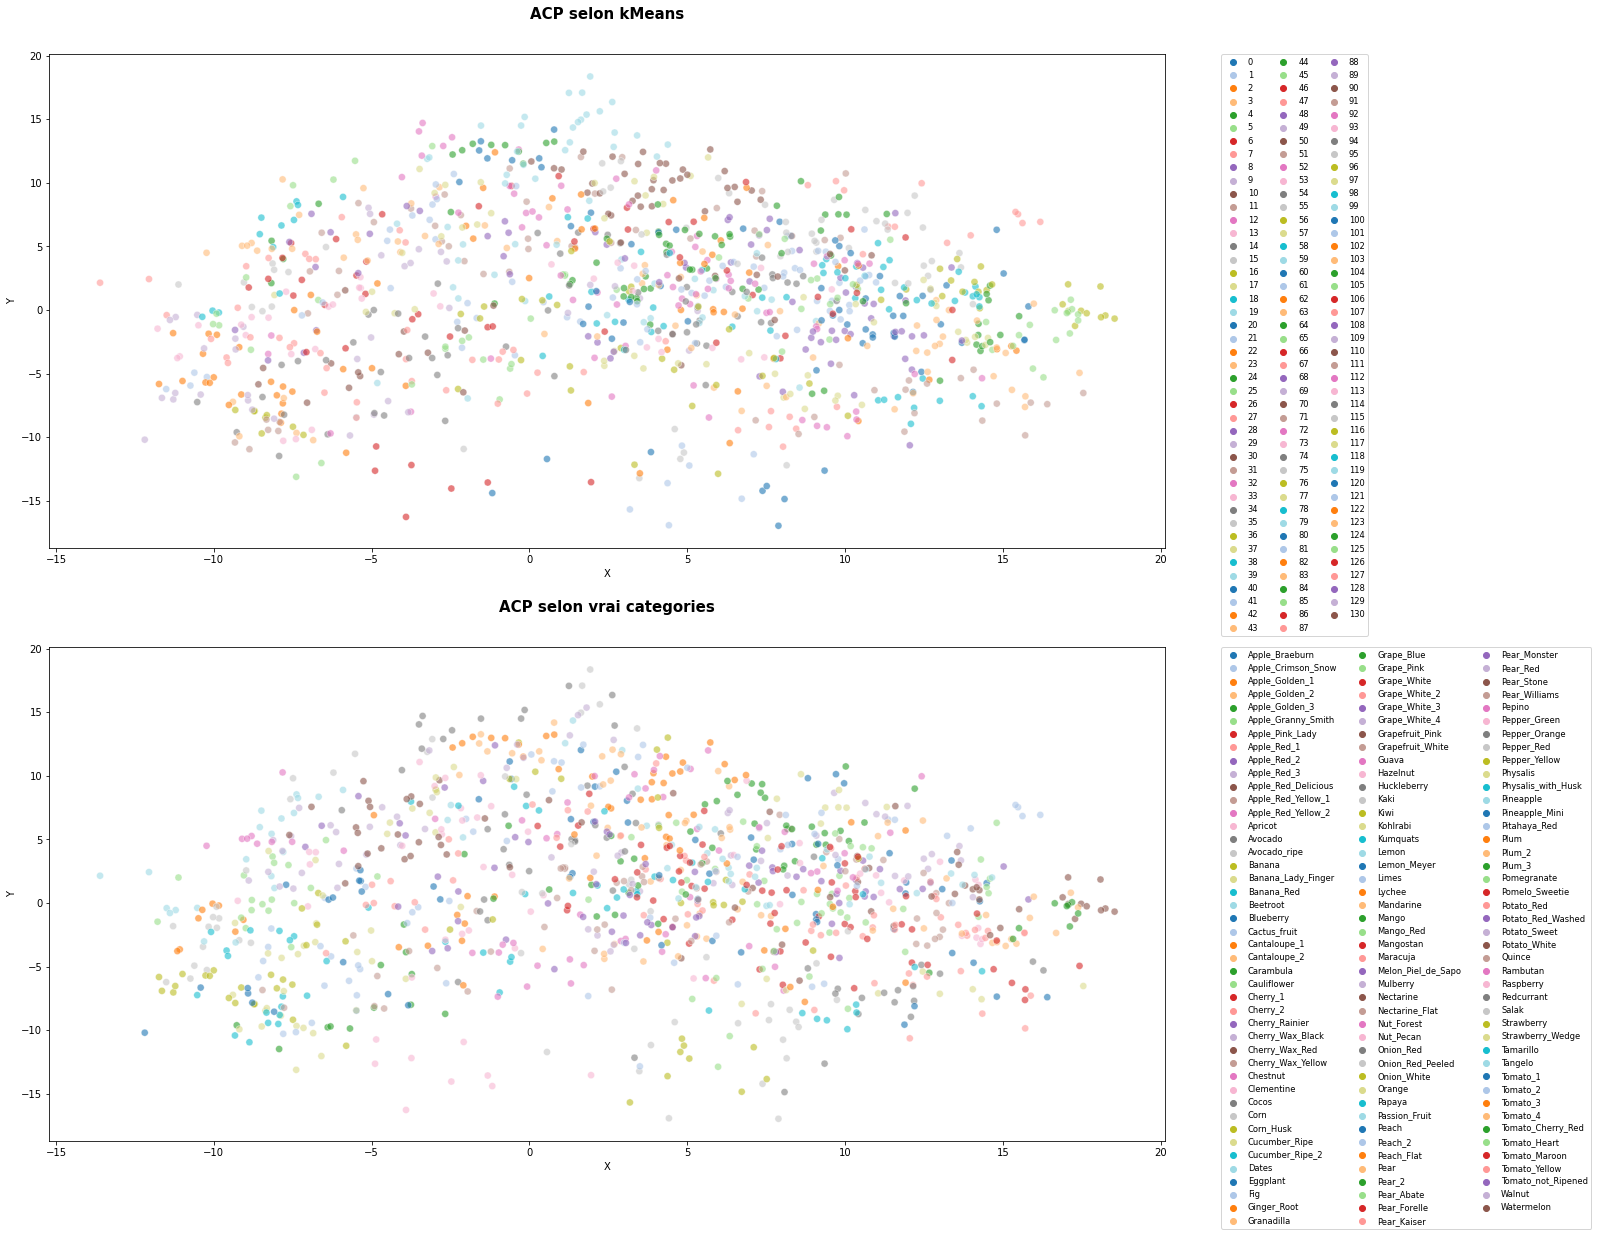

In [94]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.scatterplot(   x=pca_affic.X, y=pca_affic.Y, legend="brief", hue=km_acp.labels_, s=50, alpha=0.6, palette='tab20')
plt.title('ACP selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=3,fontsize='small')

plt.subplot(2,1,2)
sns.scatterplot(   x=pca_affic.X, y=pca_affic.Y, legend="brief", hue=df_categ.categ, s=50, alpha=0.6, palette='tab20')
plt.title('ACP selon vrai categories', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=3,fontsize='small')
plt.show()

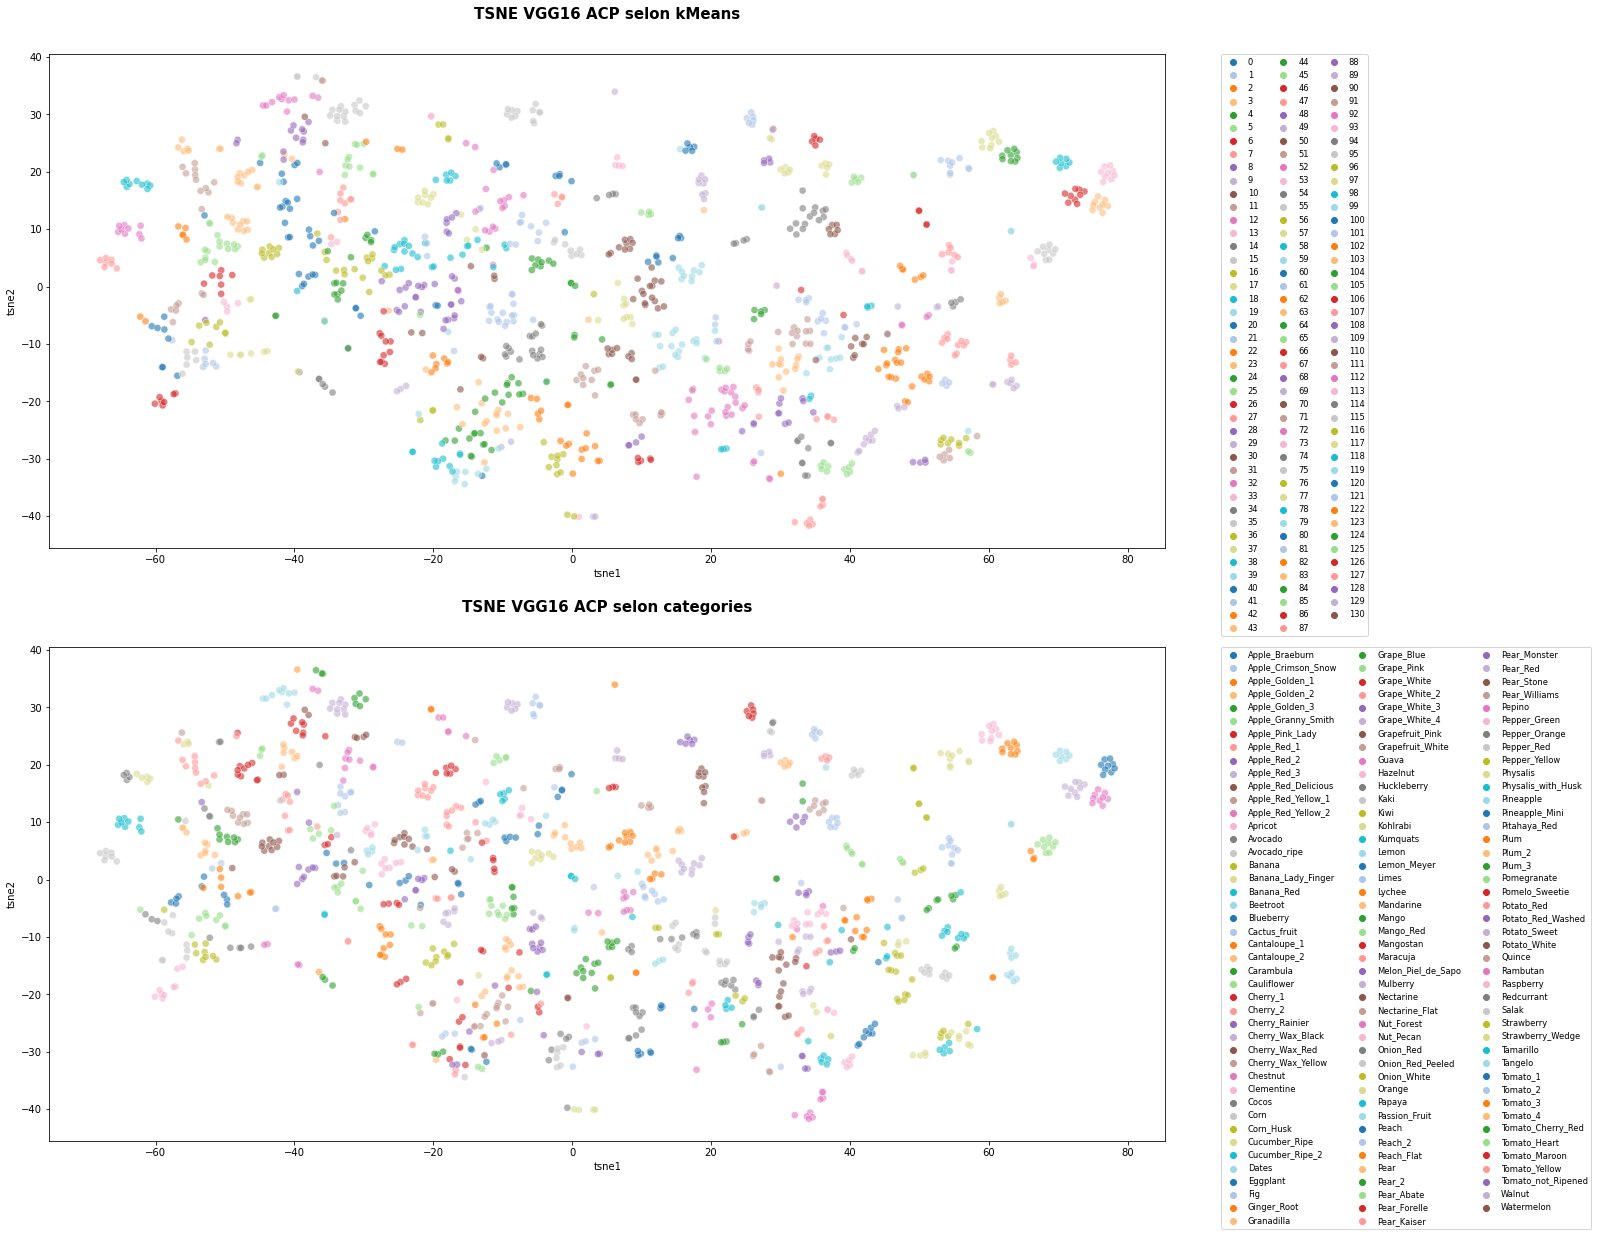

In [95]:
plt.figure(figsize=(20, 20))

plt.subplot(2,1,1)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=km_acp.labels_, s=50, alpha=0.6, palette='tab20')
plt.title('TSNE VGG16 ACP selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=3,fontsize='small')

plt.subplot(2,1,2)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=df_categ.categ, s=50, alpha=0.6, palette='tab20')
plt.title('TSNE VGG16 ACP selon categories', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, ncol=3,fontsize='small')
plt.show()